In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

## 単回帰分析

単回帰分析として, 意図的に生成したデータに対して次の処理を行って理論と一致することを確かめる.  
(1) 正規方程式を用いた方法と, scikit-learnを用いた方法で回帰係数が一致することを確かめる.  
(2) 決定係数を求める関数を作成する. またscilit-learnの関数の結果と一致することを確かめる.  
(3) 自由度調整済み決定係数を求める関数を作成する.  
(4) 残差をプロットしてみる. 系列相関の有無, 分散の不均一性, 外れ値の有無, 分布の非正規性を確認する.  

### データの仕様
ランダムに生成したn個のデータxの値からy=20+2x+$\epsilon$($\epsilon$はノイズ)なるyを計算したデータを用いる.

In [25]:
n = 50
x = np.random.normal(loc=60.0, scale=15.0, size=(n,1))
y = 20+2*x+np.random.normal(loc=0.0, scale=20.0, size=(n,1)) # ノイズの付加
df = pd.DataFrame(data=x,columns=["x"])
df["y"] = y

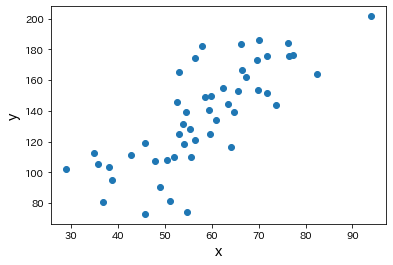

In [26]:
# データのプロット
plt.figure(facecolor="white")
plt.scatter(df["x"],df["y"])
plt.xlabel("x",fontsize=15)
plt.ylabel("y",fontsize=15)
plt.show()

### 正規方程式による回帰係数の計算
正規方程式を用いて回帰係数の計算を行う. 説明変数に成分がすべて1の列を加えた行列X, 目的変数のベクトルyとすると次の式で回帰係数$\beta$を計算できる.
$$\beta = ({}^tXX)^{-1}{}^tXy$$

In [27]:
df["s"] = 1 # 1を成分とする列を追加
X = df[["s","x"]].to_numpy() # ndarrayに変換
y = df["y"].to_numpy() # ndarrayに変換
print(X.shape,y.shape)

(50, 2) (50,)


In [28]:
B = np.linalg.inv(np.dot(X.T,X)) # Xの転置とXの積の逆行列を計算
B = np.dot(np.dot(B,X.T),y) # 先に計算した逆行列とXの転置とyの積を計算
print(B)

[24.29843364  1.92821208]


### scikit-learnによる線形回帰

In [29]:
from sklearn.linear_model import LinearRegression

# numpy形式に変換
X = df["x"].to_numpy().reshape(-1,1)
y = df["y"].to_numpy().reshape(-1,1)
model = LinearRegression() # インスタンス化
model.fit(X,y) # フィッティング

print(model.intercept_,model.coef_)

[24.29843364] [[1.92821208]]


正規方程式で計算した回帰係数と, scikit-learnで計算した回帰係数が一致していることがわかる.

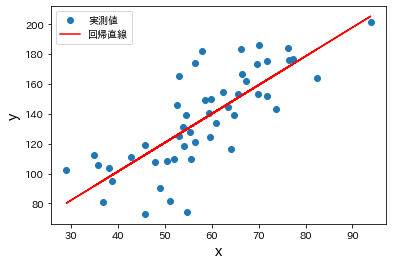

In [30]:
# 実測値と回帰直線のプロット
plt.figure(facecolor="white")
plt.scatter(df["x"],df["y"],label="実測値")
plt.plot(df["x"],model.predict(X),c="r",label="回帰直線")
plt.xlabel("x",fontsize=15)
plt.ylabel("y",fontsize=15)
plt.legend()
plt.show()

### 決定係数, 自由度調整済み決定係数


In [141]:
def R_squared(y_obs,y_pred):
    """calculate determination coefficient
    """
    RSS = np.sum((y_obs-y_pred)**2)
    sigma2_pred = RSS/(n-2)
    y_obs_squred = np.sum((y_obs-y_obs.mean())**2)
    #print("residual sum of squares(RSS) : ",RSS)
    #print("predict of sigma^2 : ",sigma2_pred)
    out = 1-RSS/y_obs_squred
    print("determination coefficient R^2: ",out)
    return out
    
    

# 自由度調整済み決定係数
def adj_R_squared(n,k,R_squared):
    """
    calculate adjusted determination cofficient
    """
    out = 1-(n-1)/(n-k-1)*(1-R_squared)
    print("adjusted determination cofficient R*^2 : ",out)
    return out

In [53]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X)

# 各種評価指標
R2 = R_squared(y,y_pred)
adj_R_squared(n,2,R2)
print("determination coefficient R^2(scikit-learn function) : ",model.score(X,y)) # scilit-learnの決定係数を求める関数
print("mean squared error(MSE) : ",mean_squared_error(y,model.predict(X)))

residual sum of squares(RSS) :  20892.00317871261
predict of sigma^2 :  435.2500662231794
determination coefficient R^2:  0.6025529316986578
adjusted determination cofficient R*^2 :  0.5856402904943453
determination coefficient R^2(scikit-learn function) :  0.6025529316986578
mean squared error(MSE) :  417.8400635742522


決定係数, 自由度調整済み決定係数, 残差平方和RSS, 誤差項の分散の推定値, MSEを求めることができた. 決定係数は自前の関数とscikit-learnの関数で値が一致していることを確認できた. 誤差項の分散の推定値は
おおよそ435で, ルートをとると20.9であるからデータの生成時に設定した値とおおよそ一致していることが確認できた.

### 残差のプロット

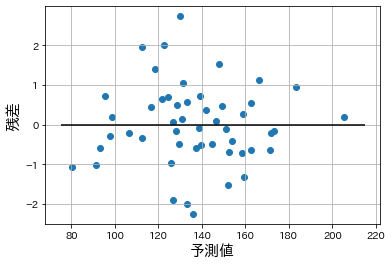

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


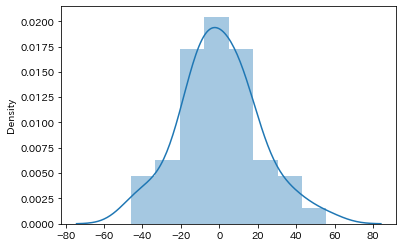

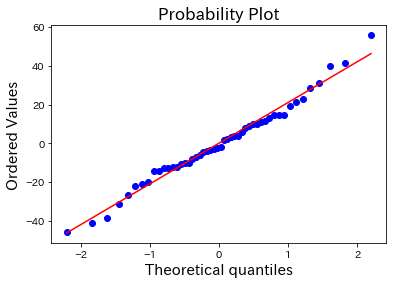

In [61]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

scaler = StandardScaler()

residual = y_pred-y
normalize_residual = scaler.fit_transform(residual)

plt.figure(facecolor="white")
plt.scatter(y_pred,normalize_residual)
plt.hlines(y = 0, xmin = 75, xmax = 215, color = 'black')
plt.xlabel("予測値",fontsize=15) # predicted value
plt.ylabel("残差",fontsize=15) # residuals
plt.grid()
plt.show()

# カーネル密度
plt.figure(facecolor='white')
sns.distplot(residual)
plt.show()

# 正規QQプロット
plt.figure(facecolor='white')
stats.probplot(residual.reshape(1,-1)[0],dist=stats.norm,plot=plt)
plt.xlabel("Theoretical quantiles",fontsize = 15)
plt.ylabel("Ordered Values",fontsize = 15)
plt.title("Probability Plot",fontsize = 17)
plt.show()

残差のプロットから系列相関の有無, 分散の不均一性, 分布の非正規性について考察する. データがバラバラに分布していることから系列相関は無いことが考えられる. 説明変数の値が大きくなるほど残差のばらつきが大きくなる傾向がないことから分散の不均一性がないことが考えられる. 標準化残差の値が-2未満または2より大きい値が2,3点あることが確認できる. このことから分布の非正規性が疑われる. しかし残差のヒストグラムやQQプロットを見るとおおよそ正規分布であるため外れ値の影響であることが考えられる.

## 重回帰分析

重回帰分析としてワインの品質を予測するデータを用いて次に示す処理を行って理論と一致することを確かめる. データとしてWine Quality Data Setを用いる. 今回は赤ワインの成分に関する情報のうちdensityとvolatile acidityから, そのワインの品質quality(0～10)を予測する.

(1) 正規方程式を用いた方法と, scikit-learnを用いた方法で回帰係数が一致することを確かめる.    
(2) 決定係数,自由度調整済み決定係数, 誤差項の推定値, 残差平方和RSSを求める.  

さらに変数選択について考える. ワインに関する特徴のうち次に設定する組み合わせの説明変数を用いたモデルを作成する. 変数選択の基準として自由度調整済み決定係数, マローズのCp基準, 赤池情報量基準の3つを用いてそれぞれ最も良いモデルがどれになるのか計算する.

選択候補1 : density, volatile acidity  
選択候補2 : density, volatile acidity, pH  
選択候補3 : fixed acidity, density, volatile acidity, pH, alcohol

Reference : https://archive.ics.uci.edu/ml/datasets/wine+quality

### データの仕様

In [136]:
df = pd.read_csv("data6.csv",sep=';')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [63]:
from sklearn.preprocessing import StandardScaler
# preprocessing

df["s"] = 1 # 切片項を追加
X = df[["s","density","volatile acidity"]] # 必要な特徴のみ抽出
y = df[["quality"]]
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X[:,0] = 1

scaler = StandardScaler()
scaler.fit(y)
y = scaler.transform(y)

### 正規方程式によるパラメータ計算

In [64]:
B = np.linalg.inv(np.dot(X.T,X)) # Xの転置とXの積の逆行列を計算
B = np.dot(np.dot(B,X.T),y) # 先に計算した逆行列とXの転置とyの積を計算
print(B)

[[-5.56130662e-15]
 [-1.66397440e-01]
 [-3.86892672e-01]]


### scikit-learnによる線形回帰

In [65]:
X = df[["density","volatile acidity"]]
y = df[["quality"]]
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

scaler = StandardScaler()
scaler.fit(y)
y = scaler.transform(y)

In [67]:
model = LinearRegression() # インスタンス化
model.fit(X,y) # フィッティング
print(model.intercept_,model.coef_)

[-5.6233462e-15] [[-0.16639744 -0.38689267]]


正規方程式を用いた方法とscikit-learnを用いた方法で回帰係数が一致していることが確認できる.

In [68]:
y_pred = model.predict(X)

# 各種評価指標
R2 = R_squared(y,y_pred)
adj_R_squared(n,2,R2)
print("determination coefficient R^2(scikit-learn function) : ",model.score(X,y)) # scilit-learnの決定係数を求める関数
print("mean squared error(MSE) : ",mean_squared_error(y,model.predict(X)))

residual sum of squares(RSS) :  1310.8441224870141
predict of sigma^2 :  27.309252551812794
determination coefficient R^2:  0.18021005472982243
adjusted determination cofficient R*^2 :  0.14532537620768715
determination coefficient R^2(scikit-learn function) :  0.18021005472982243
mean squared error(MSE) :  0.8197899452701777


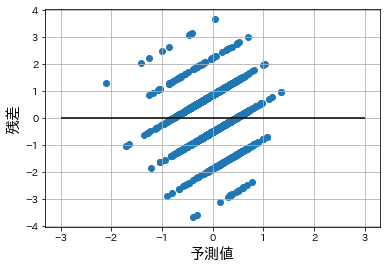

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


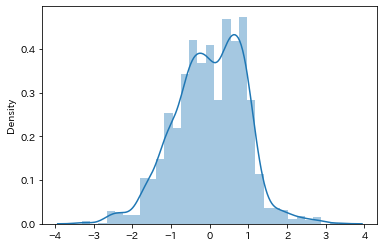

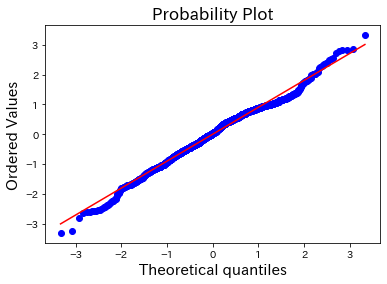

In [71]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

scaler = StandardScaler()

residual = y_pred-y
normalize_residual = scaler.fit_transform(residual)

plt.figure(facecolor="white")
plt.scatter(y_pred,normalize_residual)
plt.hlines(y = 0, xmin = -3, xmax = 3, color = 'black')
plt.xlabel("予測値",fontsize=15) # predicted value
plt.ylabel("残差",fontsize=15) # residuals
plt.grid()
plt.show()

# カーネル密度
plt.figure(facecolor='white')
sns.distplot(residual)
plt.show()

# 正規QQプロット
plt.figure(facecolor='white')
stats.probplot(residual.reshape(1,-1)[0],dist=stats.norm,plot=plt)
plt.xlabel("Theoretical quantiles",fontsize = 15)
plt.ylabel("Ordered Values",fontsize = 15)
plt.title("Probability Plot",fontsize = 17)
plt.show()

### 変数選択

赤池情報量基準(AIC)を次式で計算する.

$$n \ln(2\pi)+ n\ln(MSE)+n+2(k+2)$$

In [138]:
def mallows_cp(X_F,y,feature_list):
    """calculate mallows's Cp
    
    Args:
    X_F(DataFrame): max feature matrix
    y(DataFrame) : observed value
    feature_list(list) : selected feature name list
    
    Returns:
    mallows Cp value
    """
    n,K = X_F.shape
    K = K+1 # 切片項
    k = len(feature_list)
    
    scaler = StandardScaler()
    
    # max feature model
    X_k = X_F.copy()
    X_F["s"] = 1
    X_F = X_F.to_numpy()
    X_F = scaler.fit_transform(X_F)
    X_F[:,0] = 1
    
    y = y.to_numpy().reshape(-1,1)
    y = scaler.fit_transform(y)
    model_F = LinearRegression()
    model_F.fit(X_F,y)
    # predict of X_F
    y_pred_F = model_F.predict(X_F)
    
    # selected feature model
    X_k = X_k[feature_list]
    X_k["s"] = 1
    X_k = X_k.to_numpy()
    X_k = scaler.fit_transform(X_k)
    X_k[:,0] = 1
    
    model = LinearRegression()
    model.fit(X_k,y)
    # predict of X_k
    y_pred_k = model.predict(X_k)
    
    # cal RSS
    RSS_F = np.sum((y-y_pred_F)**2)
    sigma2_F = RSS_F/(n-2)
    RSS_k = np.sum((y-y_pred_k)**2)
    
    # cal Cp
    Cp = RSS_k/sigma2_F + 2*(k+1)
    print("mallows Cp : ",Cp)
    return Cp

def aic(X,y,feature_list):
    """calculate AIC
    """
    X = X.copy()
    n,_ = X.shape
    k = len(feature_list)
    
    scaler = StandardScaler()
    
    # selected feature model
    X = X[feature_list]
    X["s"] = 1
    X = X.to_numpy()
    X = scaler.fit_transform(X)
    X[:,0] = 1
    y = y.to_numpy().reshape(-1,1)
    y = scaler.fit_transform(y)
    
    model = LinearRegression()
    model.fit(X,y)
    # predict of X_k
    y_pred = model.predict(X)
    mse = mean_squared_error(y,y_pred)
    aic = n*np.log(2*np.pi)+n*np.log(mse)+n+2*(k+2)
    print("AIC : ",aic)
    return aic

In [144]:
feature1 = ["density","volatile acidity"]
feature2 = ["density","volatile acidity","pH"]
feature3 = ["fixed acidity", "density", "volatile acidity", "pH", "alcohol"]

scaler = StandardScaler()
X1 = df[feature1].copy()
X2 = df[feature2].copy()
X3 = df[feature3].copy()
X1["s"] = 1
X2["s"] = 1
X3["s"] = 1
y = df[["quality"]]
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X2 = scaler.fit_transform(X2)
X3 = scaler.fit_transform(X3)
X1[:,0] = 1
X2[:,0] = 1
X3[:,0] = 1

y = scaler.fit_transform(y)
model = LinearRegression()
model.fit(X1,y)
y_pred1 = model.predict(X1)
model.fit(X2,y)
y_pred2 = model.predict(X2)
model.fit(X3,y)
y_pred3 = model.predict(X3)

print("feature 1")
adj_R_squared(len(df),len(feature1),R_squared(y,y_pred1))
mallows_cp(df.drop(columns=["quality"]),df["quality"],feature1)
aic(df.drop(columns=["quality"]),df["quality"],feature1)
print("\nfeature 2")
adj_R_squared(len(df),len(feature2),R_squared(y,y_pred2))
mallows_cp(df.drop(columns=["quality"]),df["quality"],feature2)
aic(df.drop(columns=["quality"]),df["quality"],feature2)
print("\nfeature 3")
adj_R_squared(len(df),len(feature2),R_squared(y,y_pred2))
mallows_cp(df.drop(columns=["quality"]),df["quality"],feature3)
aic(df.drop(columns=["quality"]),df["quality"],feature3)

feature 1
determination coefficient R^2:  0.15253537972474862
adjusted determination cofficient R*^2 :  0.15147339398505533
mallows Cp :  2121.277289223534
AIC :  4281.121036836213

feature 2
determination coefficient R^2:  0.1537607274770556
adjusted determination cofficient R*^2 :  0.15216905486415988
mallows Cp :  2120.2188131410585
AIC :  4280.807372203196

feature 3
determination coefficient R^2:  0.1537607274770556
adjusted determination cofficient R*^2 :  0.15216905486415988
mallows Cp :  1701.1015866092828
AIC :  3927.363421333001


3927.363421333001

## 多項式回帰

### データの仕様

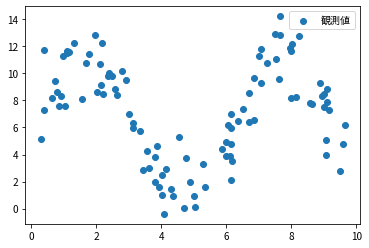

In [46]:
df = pd.read_csv("data2.csv")

plt.figure(facecolor='white')
plt.scatter(df["x"],df["y"],label='観測値')
plt.legend()

### scikit-learnによる線形回帰

In [47]:
from sklearn.preprocessing import PolynomialFeatures

X = df["x"].to_numpy().reshape(-1,1)
y = df["y"].to_numpy().reshape(-1,1)

poly_features = PolynomialFeatures(degree=4,include_bias=False)
X_poly = poly_features.fit_transform(X)

model = LinearRegression()
model.fit(X_poly,y)

LinearRegression()

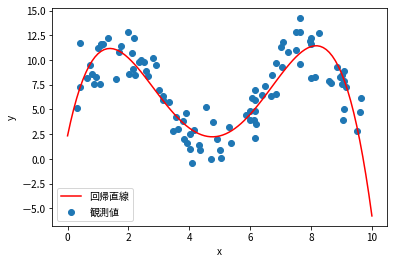

In [48]:
x_line = np.linspace(0,10,101).reshape(-1,1)
x_line_poly = poly_features.transform(x_line)
y_line = model.predict(x_line_poly)

plt.figure(facecolor="white")
plt.scatter(X,y,label="観測値")
plt.plot(x_line,y_line,color="r",label="回帰直線")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Redge回帰

### データの仕様

In [49]:
df = pd.read_csv("data3.csv")
df.head()

,x,y
0,4.337520,7.763191
1,0.201284,7.851685
2,-0.504076,7.773407
3,0.812612,9.694481
4,4.670285,7.922672


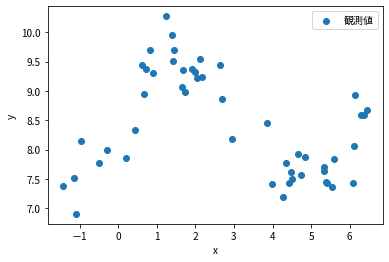

In [50]:
plt.figure(facecolor='white')
plt.scatter(df["x"],df["y"],label='観測値')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

### scikit-learnによるRedge回帰

In [51]:
degree = 4
from sklearn.preprocessing import PolynomialFeatures 

X = df["x"].to_numpy().reshape(-1,1)
y = df["y"].to_numpy().reshape(-1,1)

poly_features = PolynomialFeatures(degree=degree,include_bias=False)
X_poly = poly_features.fit_transform(X)

In [52]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=1,solver="cholesky") # コレスキーの行列分解テクニック
model.fit(X_poly,y)

Ridge(alpha=1, solver='cholesky')

In [53]:
print("切片 : ",model.intercept_[0])
print("傾き : ",model.coef_)
print("決定係数 : ",model.score(X_poly,y)) # 決定係数を計算する説明変数X,目的変数y

切片 :  8.57547440359043
傾き :  [[ 0.8949188  -0.16031769 -0.07298733  0.01201288]]
決定係数 :  0.8077718940368315


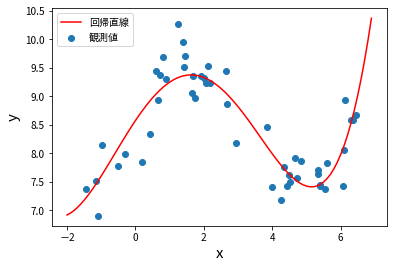

In [55]:
Xpred = np.arange(-2,7,0.1).reshape(-1,1) # プロット用の行列を生成
Xpred_poly = poly_features.fit_transform(Xpred) # フォーマット変換
ypred = model.predict(Xpred_poly) # 予測

plt.figure(facecolor="white")
plt.scatter(df["x"],df["y"],label="観測値")
plt.plot(Xpred,ypred,c="r",label="回帰直線")
plt.xlabel("x",fontsize=15)
plt.ylabel("y",fontsize=15)
plt.legend()
plt.show()

### ハイパーパラメータの効果

alpha :  0
切片 :  8.56597887870128
傾き :  [[ 0.93901737 -0.17501155 -0.07231767  0.01211205]]
回帰係数ベクトルのノルム :  0.9579974977405884
決定係数 :  0.8088602907393474

alpha :  1
切片 :  8.57547440359043
傾き :  [[ 0.8949188  -0.16031769 -0.07298733  0.01201288]]
回帰係数ベクトルのノルム :  0.9121693232130733
決定係数 :  0.8077718940368315

alpha :  10
切片 :  8.651852001923386
傾き :  [[ 0.63017781 -0.08817674 -0.0714023   0.01091736]]
回帰係数ベクトルのノルム :  0.6404035323771743
決定係数 :  0.7561351283881295



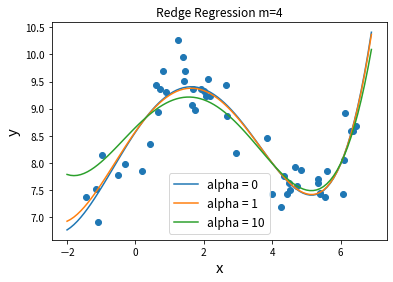

In [56]:
degree = 4
alphalist = [0,1,10]
Xpred = np.arange(-2,7,0.1).reshape(-1,1) # プロット用の行列を生成

poly_features = PolynomialFeatures(degree=degree,include_bias=False)
X_poly = poly_features.fit_transform(X)

plt.figure(facecolor="white")
for alpha in alphalist:
    model = Ridge(alpha=alpha,solver="cholesky") # コレスキーの行列分解テクニック
    model.fit(X_poly,y)
    print("alpha : ",alpha)
    print("切片 : ",model.intercept_[0])
    print("傾き : ",model.coef_)
    print("回帰係数ベクトルのノルム : ",np.linalg.norm(model.coef_))
    print("決定係数 : ",model.score(X_poly,y)) # 決定係数を計算する説明変数X,目的変数y
    print("") # 見た目
    Xpred_poly = poly_features.fit_transform(Xpred) # フォーマット変換
    ypred = model.predict(Xpred_poly) # 予測
    plt.plot(Xpred,ypred,label="alpha = "+str(alpha))

plt.scatter(df["x"],df["y"])
plt.xlabel("x",fontsize=15)
plt.ylabel("y",fontsize=15)
plt.legend(fontsize=12)
plt.title("Redge Regression m="+str(degree))
plt.show()

## Lasso回帰

### scikit-learnによるLasso回帰

In [57]:
degree = 4
from sklearn.preprocessing import PolynomialFeatures 

X = df["x"].to_numpy().reshape(-1,1)
y = df["y"].to_numpy().reshape(-1,1)

poly_features = PolynomialFeatures(degree=degree,include_bias=False)
X_poly = poly_features.fit_transform(X)

In [58]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1)
model.fit(X_poly,y)

C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3969895638884395, tolerance: 0.0038379976513810833
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [59]:
print("切片 : ",model.intercept_[0])
print("傾き : ",model.coef_)
print("決定係数 : ",model.score(X_poly,y)) # 決定係数を計算する説明変数X,目的変数y

切片 :  8.720786758836816
傾き :  [ 0.64208423 -0.16620376 -0.04314636  0.00827344]
決定係数 :  0.7587326730918746


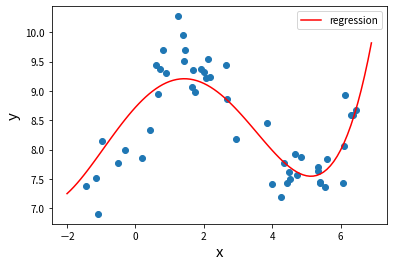

In [60]:
Xpred = np.arange(-2,7,0.1).reshape(-1,1) # プロット用の行列を生成
Xpred_poly = poly_features.fit_transform(Xpred) # フォーマット変換
ypred = model.predict(Xpred_poly) # 予測

plt.figure(facecolor="white")
plt.scatter(df["x"],df["y"])
plt.plot(Xpred,ypred,c="r",label="regression")
plt.xlabel("x",fontsize=15)
plt.ylabel("y",fontsize=15)
plt.legend()
plt.show()

### ハイパーパラメータの効果

alpha :  0.001
切片 :  8.74979108485643
傾き :  [ 0.93150135 -0.3288952  -0.01709938  0.00709959]
決定係数 :  0.7964508433943909

alpha :  0.01
切片 :  8.7450301224439
傾き :  [ 0.90524371 -0.31231061 -0.02010743  0.00726427]
決定係数 :  0.797624675394495

alpha :  0.1
切片 :  8.720786758836816
傾き :  [ 0.64208423 -0.16620376 -0.04314636  0.00827344]
決定係数 :  0.7587326730918746

alpha :  1
切片 :  8.855642851212858
傾き :  [ 0.         -0.         -0.02844317  0.00407046]
決定係数 :  0.31005181264220827



C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9101085719469837, tolerance: 0.0038379976513810833
  model = cd_fast.enet_coordinate_descent(
C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9303456685496103, tolerance: 0.0038379976513810833
  model = cd_fast.enet_coordinate_descent(
C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3969895638884395, tolerance: 0.0038379976513810833
  model = cd_fast.enet_coordinate_descent(


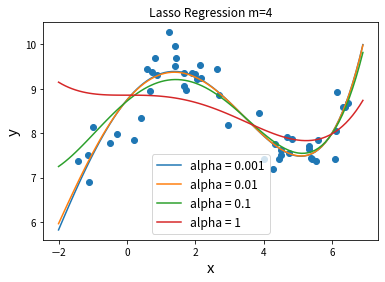

In [61]:
degree = 4
alphalist = [0.001,0.01,0.1,1]
Xpred = np.arange(-2,7,0.1).reshape(-1,1) # プロット用の行列を生成

poly_features = PolynomialFeatures(degree=degree,include_bias=False)
X_poly = poly_features.fit_transform(X)

plt.figure(facecolor="white")
for alpha in alphalist:
    model = Lasso(alpha=alpha) # コレスキーの行列分解テクニック
    model.fit(X_poly,y)
    print("alpha : ",alpha)
    print("切片 : ",model.intercept_[0])
    print("傾き : ",model.coef_)
    print("決定係数 : ",model.score(X_poly,y)) # 決定係数を計算する説明変数X,目的変数y
    print("") # 見た目
    Xpred_poly = poly_features.fit_transform(Xpred) # フォーマット変換
    ypred = model.predict(Xpred_poly) # 予測
    plt.plot(Xpred,ypred,label="alpha = "+str(alpha))

plt.scatter(df["x"],df["y"])
plt.xlabel("x",fontsize=15)
plt.ylabel("y",fontsize=15)
plt.legend(fontsize=12)
plt.title("Lasso Regression m="+str(degree))
plt.show()

## Elastic Net

### scikit-learnによるElastic Net

In [62]:
degree = 4
from sklearn.preprocessing import PolynomialFeatures 

X = df["x"].to_numpy().reshape(-1,1)
y = df["y"].to_numpy().reshape(-1,1)

poly_features = PolynomialFeatures(degree=degree,include_bias=False)
X_poly = poly_features.fit_transform(X)

In [63]:
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=0.1,l1_ratio=0.5) # l1_ratioはパラメータrのこと
model.fit(X_poly,y)

C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5290164405469, tolerance: 0.0038379976513810833
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.1)

In [64]:
print("切片 : ",model.intercept_[0])
print("傾き : ",model.coef_)
print("決定係数 : ",model.score(X_poly,y)) # 決定係数を計算する説明変数X,目的変数y

切片 :  8.740940142438433
傾き :  [ 0.70024501 -0.20802764 -0.03514978  0.00782219]
決定係数 :  0.7743179370176889


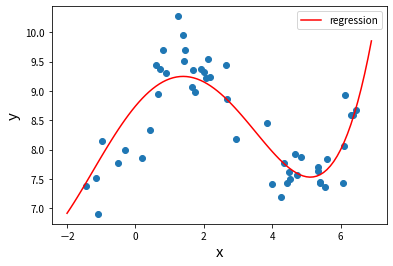

In [65]:
Xpred = np.arange(-2,7,0.1).reshape(-1,1) # プロット用の行列を生成
Xpred_poly = poly_features.fit_transform(Xpred) # フォーマット変換
ypred = model.predict(Xpred_poly) # 予測

plt.figure(facecolor="white")
plt.scatter(df["x"],df["y"])
plt.plot(Xpred,ypred,c="r",label="regression")
plt.xlabel("x",fontsize=15)
plt.ylabel("y",fontsize=15)
plt.legend()
plt.show()

### ハイパーパラメータの効果

#### alphaを変化させたとき

alpha :  0
切片 :  8.750385452096701
傾き :  [ 0.93441723 -0.33079316 -0.01674545  0.00707951]
決定係数 :  0.7962557418081162

alpha :  0.1
切片 :  8.740940142438433
傾き :  [ 0.70024501 -0.20802764 -0.03514978  0.00782219]
決定係数 :  0.7743179370176889

alpha :  1
切片 :  8.896116192063175
傾き :  [ 0.         -0.         -0.03360823  0.00491293]
決定係数 :  0.3220254869741327



<ipython-input-66-03469c2fc6e2>:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_poly,y)
C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9098499221141587, tolerance: 0.0038379976513810833
  model = cd_fast.enet_coordinate_descent(
C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5290164405469, tolerance: 0.0

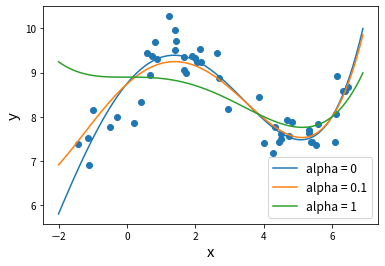

In [66]:
degree = 4
r = 0.5
alphalist = [0,0.1,1]
Xpred = np.arange(-2,7,0.1).reshape(-1,1) # プロット用の行列を生成

poly_features = PolynomialFeatures(degree=degree,include_bias=False)
X_poly = poly_features.fit_transform(X)

plt.figure(facecolor="white")
for alpha in alphalist:
    model = ElasticNet(alpha=alpha,l1_ratio=r) # コレスキーの行列分解テクニック
    model.fit(X_poly,y)
    print("alpha : ",alpha)
    print("切片 : ",model.intercept_[0])
    print("傾き : ",model.coef_)
    print("決定係数 : ",model.score(X_poly,y)) # 決定係数を計算する説明変数X,目的変数y
    print("") # 見た目
    Xpred_poly = poly_features.fit_transform(Xpred) # フォーマット変換
    ypred = model.predict(Xpred_poly) # 予測
    plt.plot(Xpred,ypred,label="alpha = "+str(alpha))

plt.scatter(df["x"],df["y"])
plt.xlabel("x",fontsize=15)
plt.ylabel("y",fontsize=15)
plt.legend(fontsize=12)
plt.show()

### rを変化させたとき

r :  0
切片 :  8.776130517489111
傾き :  [ 0.62118664 -0.19268223 -0.03313989  0.00740406]
決定係数 :  0.750609881900564

r :  0.25
切片 :  8.756020027855335
傾き :  [ 0.57297849 -0.15556294 -0.04056543  0.00784495]
決定係数 :  0.7340056854652561

r :  0.5
切片 :  8.73836531449873
傾き :  [ 0.51421512 -0.11540249 -0.04793629  0.00823932]
決定係数 :  0.7090537751859064

r :  0.75
切片 :  8.722398947094948
傾き :  [ 0.44144246 -0.06975909 -0.05576075  0.00862049]
決定係数 :  0.6716817448256639

r :  1
切片 :  8.708379129168764
傾き :  [ 0.3493224  -0.01613689 -0.06436661  0.00899822]
決定係数 :  0.614695052416331



C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.906555215939916, tolerance: 0.0038379976513810833
  model = cd_fast.enet_coordinate_descent(
C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9760416266441645, tolerance: 0.0038379976513810833
  model = cd_fast.enet_coordinate_descent(
C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.432531844218857, tolerance: 0.0038379976513810833
  model = cd_fast.enet_coordinate_descent(
C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packag

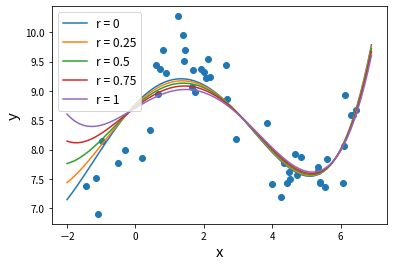

In [67]:
degree = 4
alpha = 0.2
rlist = [0,0.25,0.5,0.75,1]
Xpred = np.arange(-2,7,0.1).reshape(-1,1) # プロット用の行列を生成

poly_features = PolynomialFeatures(degree=degree,include_bias=False)
X_poly = poly_features.fit_transform(X)

plt.figure(facecolor="white")
for r in rlist:
    model = ElasticNet(alpha=alpha,l1_ratio=r) # コレスキーの行列分解テクニック
    model.fit(X_poly,y)
    print("r : ",r)
    print("切片 : ",model.intercept_[0])
    print("傾き : ",model.coef_)
    print("決定係数 : ",model.score(X_poly,y)) # 決定係数を計算する説明変数X,目的変数y
    print("") # 見た目
    Xpred_poly = poly_features.fit_transform(Xpred) # フォーマット変換
    ypred = model.predict(Xpred_poly) # 予測
    plt.plot(Xpred,ypred,label="r = "+str(r))

plt.scatter(df["x"],df["y"])
plt.xlabel("x",fontsize=15)
plt.ylabel("y",fontsize=15)
plt.legend(fontsize=12)
plt.show()